In [ ]:
#import libraries
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt # Import the relevant module
from matplotlib import pyplot

In [ ]:
def load_fashion_mnsit_dataset():
  
  # example of loading the fashion mnist dataset  
  from matplotlib import pyplot
  from keras.datasets import fashion_mnist

  # load dataset
  (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
  # summarize loaded dataset
  print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return (trainX, trainY), (testX, testY)



In [ ]:
def sample_data(train_data,test_data,num_sets):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    new_x_train, new_y_train = [], []
    new_x_test, new_y_test = [], []
    for i in range(num_sets):
        x_temp, y_temp = resample(x_train, y_train, n_samples=TRAINING_SIZE, random_state=0)
        new_x_train.append(x_temp)
        new_y_train.append(y_temp)
        x_temp, y_temp = resample(x_test, y_test, n_samples=TEST_SIZE, random_state=0)
        new_x_test.append(x_temp)
        new_y_test.append(y_temp)
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [ ]:
def get_attack_dataset(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    # set number of classes for the attack model
    num_classes = 10
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)
        #print(x_temp[0][0])

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(IN)

        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)

        #print(x_temp)
        #print(y_temp)

        for j in range(data_size):
            #print(j)
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #x_data[y_idx].append(models[i].predict(x_temp[j])[0])
            y_data[y_idx].append(OUT)
          
    return x_data, y_data

In [ ]:
def build_fcnn_model_fashion_mnist():
  from keras.models import Sequential
  from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')     
  ])
  model.summary()
  return model

In [ ]:
def get_trained_keras_models(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(tensorflow.keras.models.clone_model(keras_model))
        rms = tensorflow.keras.optimizers.RMSprop(lr=LEARNING_RATE, decay=1e-7)
        models[i].compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=32, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models=1):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
    return models

In [ ]:
def membership_attack():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  cnn_model = build_fcnn_model_fashion_mnist()  

  # compile the target model
  target_models = get_trained_keras_models(cnn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_models(attack_train, attack_test)

In [ ]:
#Set hyper-parameters for our training of neural networks
LEARNING_RATE = 0.001
EPOCH = 100
VERBOSE = 1

TRAINING_SIZE = 3000
TEST_SIZE = 2000

#No of target models
NUM_TARGET = 1 
#No of shadow models
NUM_SHADOW = 6

#Label value "in" for records present in training data of shadow models 
IN = 1
#Label value "out" for records not present in training data of shadow models 
OUT = 0

Increase number of layers to get Denser Model

In [ ]:
def build_fcnn_model_fashion_mnist_denser():

  from tensorflow import keras
  from tensorflow.keras import layers, models
  
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')     
  ])

  model.summary()
  return model


#Reference:
#https://cloudxlab.com/blog/fashion-mnist-using-deep-learning-with-tensorflow-keras/

In [ ]:
def membership_attack_using_FCNN_Denser():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  nn_model = build_fcnn_model_fashion_mnist_denser()
  
  # compile the target model
  target_models = get_trained_keras_models(nn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(nn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_models(attack_train, attack_test)




Introduce Dropout in the Dense Network

In [ ]:
def build_fcnn_model_fashion_mnist_denser_with_dropout():
  model = tf.keras.models.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')     
  ])

  model.summary()
  return model

In [ ]:
def membership_attack_using_FCNN_Denser_with_Dropout():

  # load the pre-shuffled train and test data
  (x_train, y_train), (x_test, y_test) = load_fashion_mnsit_dataset()

  # split the data for each model
  target_train = (x_train[:TRAINING_SIZE*NUM_TARGET],y_train[:TRAINING_SIZE*NUM_TARGET])
  target_test = (x_test[:TEST_SIZE*NUM_TARGET],y_test[:TEST_SIZE*NUM_TARGET])
  target_train_data, target_test_data = sample_data(target_train, target_test, NUM_TARGET)

  shadow_train = (x_train[TRAINING_SIZE*NUM_TARGET:],y_train[TRAINING_SIZE*NUM_TARGET:])
  shadow_test = (x_test[TEST_SIZE*NUM_TARGET:],y_test[TEST_SIZE*NUM_TARGET:])
  shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

  #cnn_model = build_fcnn_model()
  nn_model = build_fcnn_model_fashion_mnist_denser_with_dropout()
  
  # compile the target model
  target_models = get_trained_keras_models(nn_model, target_train_data, target_test_data, NUM_TARGET)
  # compile the shadow models
  shadow_models = get_trained_keras_models(nn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

  # get train data for the attack model
  attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
  # get test data for the attack model
  attack_test = get_attack_dataset(target_models, target_train_data, target_test_data, NUM_TARGET, TEST_SIZE)

  # training the attack model
  attack_model = get_trained_svm_models(attack_train, attack_test)




Run Each Attack for :

1. Dense Network without dropout

2. Dense Network with Dropout

In [1]:
attack_accuracy_dense=[]
attack_accuracy_dropout=[]
no_of_shadow_models=[]

In [ ]:
NUM_SHADOW = 2
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.3789 - accuracy: 0.5197
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.6907
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1252 - accuracy: 0.7410
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1184 - accuracy: 0.7587
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1060 - accuracy: 0.7863
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0975 - accuracy: 0.8163
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.8260
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0801 - accuracy: 0.8383
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0879 - accuracy: 0.8363
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0758 - accuracy: 0.8527
Epoch 11/

In [2]:
no_of_shadow_models.append(2)
attack_accuracy_dense.append(0.6370)

In [ ]:
NUM_SHADOW = 2
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               100480    
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6851 - accuracy: 0.1877
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 0.2691 - accuracy: 0.4150
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2048 - accuracy: 0.5507
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.6497
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1531 - accuracy: 0.6837
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1425 - accuracy: 0.6937
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.7243
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1250 - accuracy: 0.7343
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1133 - accuracy: 0.7423
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1110 - accuracy: 0.7553
Epoch 11/

In [3]:
attack_accuracy_dropout.append(0.5725)

In [ ]:
NUM_SHADOW = 3
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_130 (Dense)           (None, 128)               100480    
                                                                 
 dense_131 (Dense)           (None, 128)               16512     
                                                                 
 dense_132 (Dense)           (None, 128)               16512     
                                                                 
 dense_133 (Dense)           (None, 128)               16512     
                                                                 
 dense_134 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6224 - accuracy: 0.5107
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1656 - accuracy: 0.6773
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1304 - accuracy: 0.7273
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1153 - accuracy: 0.7717
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1038 - accuracy: 0.7893
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1000 - accuracy: 0.8077
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0889 - accuracy: 0.8200
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0872 - accuracy: 0.8377
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.8417
Epoch 10/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0773 - accuracy: 0.8560
Epoch 11/

In [4]:
no_of_shadow_models.append(3)

attack_accuracy_dense.append(0.6370)

In [ ]:
NUM_SHADOW = 3
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_138 (Dense)           (None, 128)               100480    
                                                                 
 dense_139 (Dense)           (None, 128)               16512     
                                                                 
 dense_140 (Dense)           (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_141 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6452 - accuracy: 0.2130
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.4090
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2116 - accuracy: 0.5530
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.6543
Epoch 5/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1528 - accuracy: 0.6803
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1362 - accuracy: 0.7017
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1288 - accuracy: 0.7323
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1270 - accuracy: 0.7243
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1173 - accuracy: 0.7443
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1145 - accuracy: 0.7507
Epoch 11/

In [5]:
attack_accuracy_dropout.append(0.5672)

In [ ]:
NUM_SHADOW = 4
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.4406 - accuracy: 0.5177
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1591 - accuracy: 0.6863
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1342 - accuracy: 0.7243
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1193 - accuracy: 0.7657
Epoch 5/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1030 - accuracy: 0.7937
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0938 - accuracy: 0.8053
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 0.0895 - accuracy: 0.8230
Epoch 8/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0851 - accuracy: 0.8310
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.8420
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 0.0736 - accuracy: 0.8573
Epoch 11/

In [6]:
no_of_shadow_models.append(4)


attack_accuracy_dense.append(0.6075)

In [ ]:
NUM_SHADOW = 4
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               100480    
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.7107 - accuracy: 0.1753
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2920 - accuracy: 0.3493
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2249 - accuracy: 0.5303
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1792 - accuracy: 0.6223
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1543 - accuracy: 0.6650
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1378 - accuracy: 0.7033
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1294 - accuracy: 0.7137
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1183 - accuracy: 0.7380
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1188 - accuracy: 0.7357
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1137 - accuracy: 0.7400
Epoch 11/

In [7]:
attack_accuracy_dropout.append(0.5779)

In [ ]:
NUM_SHADOW = 5
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               100480    
                                                                 
 dense_35 (Dense)            (None, 128)               16512     
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.4311 - accuracy: 0.5537
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1610 - accuracy: 0.6977
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1221 - accuracy: 0.7570
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1086 - accuracy: 0.7890
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1047 - accuracy: 0.7943
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0976 - accuracy: 0.8043
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0888 - accuracy: 0.8210
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0833 - accuracy: 0.8287
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.8487
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0742 - accuracy: 0.8587
Epoch 11/

In [8]:
no_of_shadow_models.append(5)


attack_accuracy_dense.append(0.6344)

In [ ]:
NUM_SHADOW = 5
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               100480    
                                                                 
 dense_43 (Dense)            (None, 128)               16512     
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.7201 - accuracy: 0.1987
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2709 - accuracy: 0.4227
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2042 - accuracy: 0.5760
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1693 - accuracy: 0.6533
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1474 - accuracy: 0.6800
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1418 - accuracy: 0.7050
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1334 - accuracy: 0.7193
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1244 - accuracy: 0.7327
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1224 - accuracy: 0.7350
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1138 - accuracy: 0.7400
Epoch 11/

In [9]:
attack_accuracy_dropout.append(0.5)

In [ ]:
NUM_SHADOW = 6
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_58 (Dense)            (None, 128)               100480    
                                                                 
 dense_59 (Dense)            (None, 128)               16512     
                                                                 
 dense_60 (Dense)            (None, 128)               16512     
                                                                 
 dense_61 (Dense)            (None, 128)               16512     
                                                                 
 dense_62 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.4204 - accuracy: 0.5250
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1663 - accuracy: 0.6923
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1322 - accuracy: 0.7303
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1156 - accuracy: 0.7633
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1043 - accuracy: 0.7943
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1020 - accuracy: 0.8087
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0912 - accuracy: 0.8167
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0823 - accuracy: 0.8287
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0824 - accuracy: 0.8397
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0749 - accuracy: 0.8517
Epoch 11/

In [10]:
no_of_shadow_models.append(6)

attack_accuracy_dense.append(0.6263)

In [ ]:
NUM_SHADOW = 6
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_66 (Dense)            (None, 128)               100480    
                                                                 
 dense_67 (Dense)            (None, 128)               16512     
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 128)               16512     
                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6718 - accuracy: 0.1797
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2997 - accuracy: 0.3510
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 0.2213 - accuracy: 0.5213
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1867 - accuracy: 0.6230
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1611 - accuracy: 0.6533
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1504 - accuracy: 0.6840
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1384 - accuracy: 0.7047
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1324 - accuracy: 0.7163
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1259 - accuracy: 0.7267
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1246 - accuracy: 0.7303
Epoch 11/

In [11]:
attack_accuracy_dropout.append(0.5967)

In [ ]:
NUM_SHADOW = 7
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               100480    
                                                                 
 dense_75 (Dense)            (None, 128)               16512     
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dense_77 (Dense)            (None, 128)               16512     
                                                                 
 dense_78 (Dense)            (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.3988 - accuracy: 0.5123
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1583 - accuracy: 0.6727
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1307 - accuracy: 0.7243
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1156 - accuracy: 0.7557
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1067 - accuracy: 0.7787
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0946 - accuracy: 0.8060
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0916 - accuracy: 0.8277
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.8350
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0847 - accuracy: 0.8397
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0720 - accuracy: 0.8577
Epoch 11/

In [12]:
no_of_shadow_models.append(7)


attack_accuracy_dense.append(0.6370)

In [ ]:
NUM_SHADOW = 7
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_82 (Dense)            (None, 128)               100480    
                                                                 
 dense_83 (Dense)            (None, 128)               16512     
                                                                 
 dense_84 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6864 - accuracy: 0.1760
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.3041 - accuracy: 0.3527
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.2353 - accuracy: 0.4953
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1932 - accuracy: 0.5940
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1667 - accuracy: 0.6463
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1567 - accuracy: 0.6847
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1412 - accuracy: 0.7010
Epoch 8/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1292 - accuracy: 0.7133
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1263 - accuracy: 0.7223
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1124 - accuracy: 0.7400
Epoch 11/

In [13]:
attack_accuracy_dropout.append(0.5698)

In [ ]:
NUM_SHADOW = 8
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_98 (Dense)            (None, 128)               100480    
                                                                 
 dense_99 (Dense)            (None, 128)               16512     
                                                                 
 dense_100 (Dense)           (None, 128)               16512     
                                                                 
 dense_101 (Dense)           (None, 128)               16512     
                                                                 
 dense_102 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.5348 - accuracy: 0.5083
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.6720
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1374 - accuracy: 0.7153
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1137 - accuracy: 0.7520
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1062 - accuracy: 0.7867
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0988 - accuracy: 0.8083
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0898 - accuracy: 0.8163
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0875 - accuracy: 0.8327
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0846 - accuracy: 0.8420
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0763 - accuracy: 0.8477
Epoch 11/

In [14]:
no_of_shadow_models.append(8)

attack_accuracy_dense.append(0.6263)

In [ ]:
NUM_SHADOW = 8
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_106 (Dense)           (None, 128)               100480    
                                                                 
 dense_107 (Dense)           (None, 128)               16512     
                                                                 
 dense_108 (Dense)           (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_109 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 3s 5ms/step - loss: 0.7912 - accuracy: 0.1730
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 0.2976 - accuracy: 0.3587
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 0.2187 - accuracy: 0.5487
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1783 - accuracy: 0.6233
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1570 - accuracy: 0.6717
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1529 - accuracy: 0.6803
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1406 - accuracy: 0.7010
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1295 - accuracy: 0.7280
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1263 - accuracy: 0.7327
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1194 - accuracy: 0.7317
Epoch 11/

In [15]:
attack_accuracy_dropout.append(0.6102)

In [ ]:
NUM_SHADOW = 9
attack_model = membership_attack_using_FCNN_Denser()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 dense_114 (Dense)           (None, 128)               100480    
                                                                 
 dense_115 (Dense)           (None, 128)               16512     
                                                                 
 dense_116 (Dense)           (None, 128)               16512     
                                                                 
 dense_117 (Dense)           (None, 128)               16512     
                                                                 
 dense_118 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.3896 - accuracy: 0.4993
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1644 - accuracy: 0.6767
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1292 - accuracy: 0.7307
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1147 - accuracy: 0.7610
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 0.1034 - accuracy: 0.7870
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0969 - accuracy: 0.8087
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0993 - accuracy: 0.8227
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.8343
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0836 - accuracy: 0.8453
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0734 - accuracy: 0.8533
Epoch 11/

In [16]:
no_of_shadow_models.append(9)

attack_accuracy_dense.append(0.6317)

In [ ]:
NUM_SHADOW = 9
attack_model = membership_attack_using_FCNN_Denser_with_Dropout()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_122 (Dense)           (None, 128)               100480    
                                                                 
 dense_123 (Dense)           (None, 128)               16512     
                                                                 
 dense_124 (Dense)           (None, 128)               16512     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_125 (Dense)           (None, 128)               16512     
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
94/94 [==============================] - 2s 6ms/step - loss: 0.6104 - accuracy: 0.2037
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 0.2728 - accuracy: 0.4103
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 0.2186 - accuracy: 0.5377
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1813 - accuracy: 0.6240
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1559 - accuracy: 0.6810
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1420 - accuracy: 0.7043
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1329 - accuracy: 0.7123
Epoch 8/100
94/94 [==============================] - 1s 5ms/step - loss: 0.1266 - accuracy: 0.7260
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1275 - accuracy: 0.7317
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 0.1106 - accuracy: 0.7393
Epoch 11/

In [17]:
attack_accuracy_dropout.append(0.5860)

In [18]:
attack_accuracy_dense

[0.637, 0.637, 0.6075, 0.6344, 0.6263, 0.637, 0.6263, 0.6317]

In [19]:
attack_accuracy_dropout

[0.5725, 0.5672, 0.5779, 0.5, 0.5967, 0.5698, 0.6102, 0.586]

In [20]:
no_of_shadow_models

[2, 3, 4, 5, 6, 7, 8, 9]

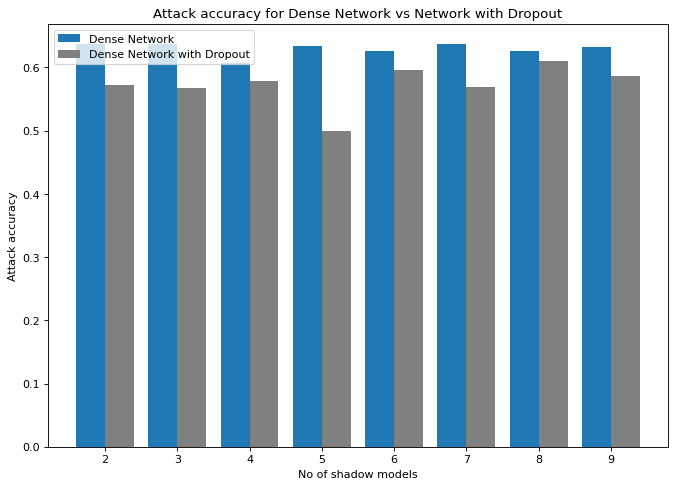

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7), dpi=80)

X_axis = np.arange(len(no_of_shadow_models))
  
plt.bar(X_axis - 0.2, attack_accuracy_dense, 0.4, label = 'Dense Network')
plt.bar(X_axis + 0.2, attack_accuracy_dropout, 0.4, label = 'Dense Network with Dropout', color='grey')
  
plt.xticks(X_axis, no_of_shadow_models)

plt.xlabel("No of shadow models")
plt.ylabel("Attack accuracy")
plt.title("Attack accuracy for Dense Network vs Network with Dropout")
plt.legend()

plt.show()